### Simple Moving Average Strategy
 
<font color='orange'>
    For a certain security, calculate simple average (e.g. mean, median, etc.) over different sizes of rolling windows, then use cross-over strategy (i.e. when the shorter-term moving average crosses above the longer-term moving average, it is considered as a bullish signal, indicating a potential uptrend, and vice versa) to generate trading signals.
    $$
    \text { Simple Moving Average }=\frac{\left(A_1+A_2+\ldots \ldots+A_n\right)}{n}
    $$
</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cufflinks as cf
from scipy.optimize import brute
from datetime import datetime
from collections import namedtuple
import math
from numbers import Real
import jdc
plt.style.use('seaborn')

/var/folders/6b/zsc6z0x51ls8w8wy4m79d0y80000gn/T/ipykernel_29858/2261596742.py:11: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



> #### Implementation:

In [2]:
class SMA:
    '''
    Description: 
        Class for the vectorized backtesting of SMA-based trading strategies.

    Properties:
    ===========
    symbol: str
        ticker symbol
    sma_s: int
        time window in days for shorter SMA
    sma_l: int
        time window in days for longer SMA
    start_date: str or datetime
        start date for data retrieval
    end_date: str or datetime
        end date for data retrieval
    tc: Real
        proportional transaction costs per trade

    Methods:
    ========
    load_data:
        retrieve and prepare data given a file path
    prepare_data:
        prepare data
    run_strategy:
        run the backtest for the SMA strategy
    run_with_updated_params:
        update SMA parameters and rerun SMA strategy
    optimize_params:
        implement a brute force optimization to search for optimal SMA parameters
    plot_result:
        plot the performance of the SMA strategy compared to buy-and-hold strategy
    '''
    def __init__(self, symbol, sma_s, sma_l, start_date, end_date, tc):
        self._symbol = symbol
        self._sma_s = sma_s
        self._sma_l = sma_l
        self._start_date = start_date
        self._end_date = end_date
        self._tc = tc
        
        self.path = None
        self.data = None
        self.result = None
        self.perf = None

    def __repr__(self):
        return f'SMABackTester(symbol: {self.symbol}, sma_short: {self.sma_s}, sma_long: {self.sma_l}, start_date: {self.start_date}, end_date: {self.end_date})'

    # Symbol
    @property
    def symbol(self):
        return self._symbol
    @symbol.setter
    def symbol(self, symbol):
        if isinstance(symbol, str):
            self._symbol = symbol
            if self.data is not None:
                self.prepare_data()
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('Symbol must be a string.')

    # Sma_short
    @property
    def sma_s(self):
        return self._sma_s
    @sma_s.setter
    def sma_s(self, sma_s):
        if isinstance(sma_s, int):
            self._sma_s = sma_s
            if self.data is not None:
                self.prepare_data()
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('Sma_short must be an integer.')

    # Sma_long
    @property
    def sma_l(self):
        return self._sma_l
    @sma_l.setter
    def sma_l(self, sma_l):
        if isinstance(sma_l, int):
            self._sma_l = sma_l
            if self.data is not None:
                self.prepare_data()
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('Sma_long must be an integer.')

    # Start_date
    @property
    def start_date(self):
        return self._start_date
    @start_date.setter
    def start_date(self, start_date):
        if isinstance(start_date, str):
            self._start_date = start_date 
        elif isinstance(start_date, datetime):
            self._start_date = start_date.strftime('%Y-%m-%d')
        else:
            raise ValueError('Start_date must be a string or a datetime object.')
            
        if self.data is not None:
            self.prepare_data()
        if self.result is not None:
            self.run_strategy()

    # End_date
    @property
    def end_date(self):
        return self._end_date
    @end_date.setter
    def end_date(self, end_date):
        if isinstance(end_date, str):
            self._end_date = end_date 
        elif isinstance(end_date, datetime):
            self._end_date = end_date.strftime('%Y-%m-%d')
        else:
            raise ValueError('End_date must be a string or a datetime object.')
            
        if self.data is not None:
            self.prepare_data()
        if self.result is not None:
            self.run_strategy()

    @property
    def tc(self):
        return self._tc
    @tc.setter
    def tc(self, tc):
        if isinstance(tc, Real):
            self._tc = tc
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('Trading_cost must be a real number.')

In [3]:
%%add_to SMA
def load_data(self, path):
    '''
    Retrieve and prepare the data given a file path.
    '''
    if isinstance(path, str):
        self.path = path
    else:
        raise ValueError('File path of data must be a string.')
    self.prepare_data()

In [4]:
%%add_to SMA
def prepare_data(self):
    '''
    Prepare data.
    '''
    # Load data
    self.data = pd.read_csv(self.path, parse_dates=['Date'], index_col='Date')
    # Filter data for given symbol
    self.data = self.data[self.symbol].to_frame().dropna()
    # Filter data for given period
    self.data = self.data.loc[self.start_date : self.end_date].copy()
    self.data.rename(columns={self.symbol: 'Price'}, inplace=True)
    
    # sma_short
    self.data['SMA_S'] = self.data['Price'].rolling(self.sma_s).mean()
    # sma_long
    self.data['SMA_L'] = self.data['Price'].rolling(self.sma_l).mean()
    # If sma_s > sma_l, hold long position and otherwise short
    self.data['Position'] = np.where(self.data['SMA_S'] > self.data['SMA_L'], 1, -1)
    
    # Return of buy-and-hold strategy
    return_buy_and_hold = self.data['Price'] / self.data['Price'].shift(1)
    # Return (log) of buy-and-hold strategy
    self.data['Return_Buy_Hold(log)'] = np.log(return_buy_and_hold)
    # Cumulative return of buy-and-hold strategy
    self.data['Return_Buy_Hold(cum)'] = self.data['Return_Buy_Hold(log)'].cumsum().apply(np.exp)

In [5]:
%%add_to SMA
def run_strategy(self):
    '''
    Backtest the SMA strategy.
    '''
    data = self.data.copy().dropna()
    # Number of trades
    data['Trades'] = data['Position'].diff().fillna(0).abs()
    
    # Return of sma strategy (position of previous day * return of current day)
    data['Return_SMA(log)'] = data['Position'].shift(1) * data['Return_Buy_Hold(log)']
    data.dropna(inplace=True)
    # Return of sma strategy (excluding trading cost)
    data['Return_SMA_Net(log)'] = data['Return_SMA(log)'] - data['Trades'] * self.tc
    
    # Cumulative return of sma strategy
    data['Return_SMA(cum)'] = data['Return_SMA(log)'].cumsum().apply(np.exp)
    # Cumulative return of sma strategy (excluding trading cost)
    data['Return_SMA_Net(cum)'] = data['Return_SMA_Net(log)'].cumsum().apply(np.exp)
    self.result = data

    abs_perf = self.result['Return_SMA(cum)'].iloc[-1]
    out_perf = abs_perf - data['Return_Buy_Hold(cum)'].iloc[-1]

    self.perf = namedtuple('sma_performance', ['sma_abs_performance', 'sma_out_performance'])
    self.perf.sma_abs_performance = round(abs_perf, 6)
    self.perf.sma_out_performance = round(out_perf, 6)
    return self.perf.sma_abs_performance

In [6]:
%%add_to SMA
def run_with_updated_params(self, sma):
    '''
    Update SMA parameters and rerun SMA strategy.

    Parameters:
    ===========
    sma: tuple
        sma parameter tuple
    '''
    self.sma_s = int(sma[0])
    self.sma_l = int(sma[1])
    return -self.run_strategy()

In [7]:
%%add_to SMA
def optimize_params(self, sma_s_range, sma_l_range):
    '''
    Find optimal sma_short and sma_long combination in terms of best possible SMA return.
    
    Parameters:
    ===========
    sma_s_range, sma_l_range: tuple
        sma ranges tuples      
    '''
    opt = brute(self.run_with_updated_params, ranges=(sma_s_range, sma_l_range), finish=None)
    return opt

In [8]:
%%add_to SMA
def plot_result(self):
    '''
    Plots the cumulative performance of the SMA strategy comparing to buy-and-hold.
    '''
    if self.result is None:
        print('No result for display, please run the strategy')
    else:
        title = f'{self.symbol} | SMA_S = {self.sma_s} | SMA_L = {self.sma_l} | TC = {self.tc}'
        self.result[['Return_Buy_Hold(cum)', 'Return_SMA(cum)', 'Return_SMA_Net(cum)']].plot(title=title, figsize=(12, 8))        

> #### Example:

In [9]:
PATH = './data/forex_pairs.csv'

SMA_SHORT = 50
SMA_LONG = 200
SMA_S_RANGE = (30, 50, 1)
SMA_L_RANGE = (100, 150, 1)

SYMBOL = 'EURUSD=X'
START_DATE = '2004-01-01'
END_DATE = '2020-06-30'
TRADING_COST = 0.00007

In [10]:
sma = SMA(symbol=SYMBOL, 
          sma_s=SMA_SHORT, 
          sma_l=SMA_LONG,
          start_date=START_DATE,
          end_date=END_DATE,
          tc=TRADING_COST)
sma

SMABackTester(symbol: EURUSD=X, sma_short: 50, sma_long: 200, start_date: 2004-01-01, end_date: 2020-06-30)

In [11]:
sma.load_data(path = PATH)
sma.data.head()

,Price,SMA_S,SMA_L,Position,Return_Buy_Hold(log),Return_Buy_Hold(cum)
Date,,,,,,
2004-01-01,1.258194,NaN,NaN,-1,NaN,NaN
2004-01-02,1.258194,NaN,NaN,-1,0.000000,1.000000
2004-01-05,1.268698,NaN,NaN,-1,0.008313,1.008348
2004-01-06,1.272103,NaN,NaN,-1,0.002681,1.011055
2004-01-07,1.264095,NaN,NaN,-1,-0.006315,1.004690


In [12]:
sma.run_strategy()
sma.result.head()

,Price,SMA_S,SMA_L,Position,Return_Buy_Hold(log),Return_Buy_Hold(cum),Trades,Return_SMA(log),Return_SMA_Net(log),Return_SMA(cum),Return_SMA_Net(cum)
Date,,,,,,,,,,,
2004-10-07,1.229906,1.221840,1.226081,-1,0.001475,0.977517,0.0,-0.001475,-0.001475,0.998526,0.998526
2004-10-08,1.241003,1.222628,1.225995,-1,0.008982,0.986337,0.0,-0.008982,-0.008982,0.989598,0.989598
2004-10-11,1.238405,1.223352,1.225843,-1,-0.002095,0.984272,0.0,0.002095,0.002095,0.991673,0.991673
2004-10-12,1.232104,1.223888,1.225643,-1,-0.005102,0.979264,0.0,0.005102,0.005102,0.996746,0.996746
2004-10-13,1.234903,1.224466,1.225497,-1,0.002270,0.981489,0.0,-0.002270,-0.002270,0.994486,0.994486


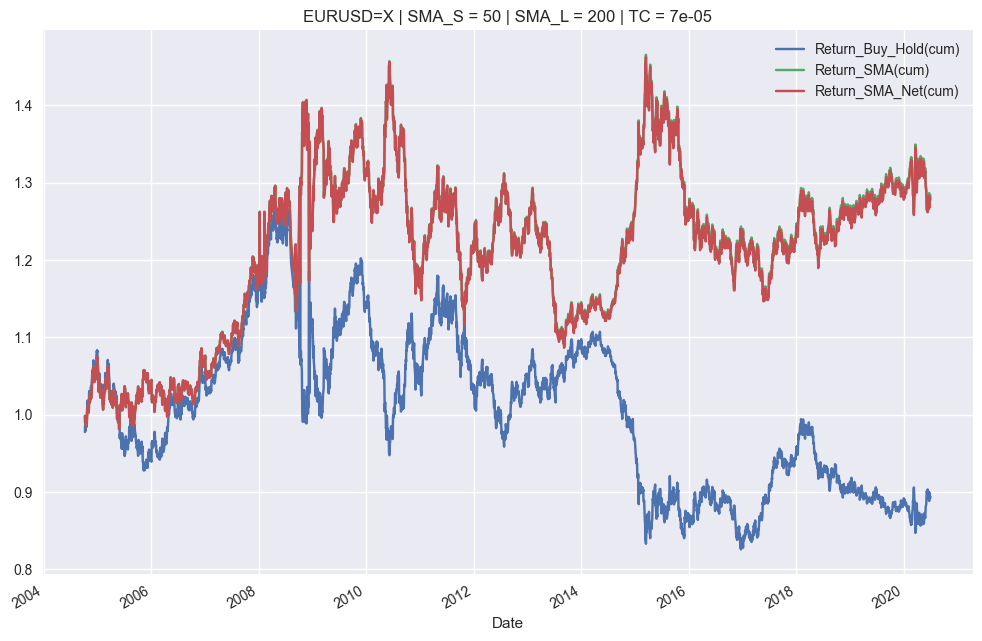

In [13]:
sma.plot_result()

In [14]:
sma.optimize_params(sma_s_range=SMA_S_RANGE, sma_l_range=SMA_L_RANGE)

array([ 46., 137.])